In [1]:
#data prep
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import Series
from matplotlib.patches import Circle
import seaborn as sns
from datetime import datetime,timedelta
import numpy  as np
import scipy.stats as stats
from sklearn.cluster import KMeans
zscore_limit = 3
def cleanUpOutliars(df):
    df['Caudal'] = df['Caudal'].clip(upper=40, lower=-20)
    df['zscore'] = stats.zscore(df.Caudal)
    df['mean12'] = df['Caudal'].rolling(24).mean()
    df.loc[df['zscore'] > zscore_limit, 'Caudal'] = df['mean12']


def dataPrep():
    # get data
    dfCaudal = pd.read_excel(r'caudal.xlsx')
    dfCaudal = pd.DataFrame(dfCaudal, columns=['Tempo', 'Caudal'])
    
    # data setup
    dfCaudal['Tempo'] = pd.to_datetime(dfCaudal['Tempo'])
    dfCaudal['Caudal'] = pd.to_numeric(dfCaudal['Caudal'], errors='coerce')
    dfCaudal.set_index('Tempo', inplace=True)
    dfCaudal.dropna(inplace=True)
    
    # split by invalid points - points where time diff is too big > 7
    dfCaudal['timediff'] = dfCaudal.index.to_series().diff()
    dfCaudal.dropna(inplace=True)
    dataSetCuts = dfCaudal[dfCaudal['timediff'] > timedelta(hours=7)]
    
    # zero values were considered
    #dfCaudal =  dfCaudal[dfCaudal['Caudal'] != 0]
    dataSetCuts = pd.concat([dfCaudal.head(1), dataSetCuts, dfCaudal.tail(1)])
    dataSetLists = []
    prev_row = None
    for index, row in  dataSetCuts.iterrows():
         if prev_row is None:
            prev_row = row
         else:
            dataSetLists.append(dfCaudal.loc[prev_row.name:row.name, :].copy())
            prev_row = row
    
    
    # get first and second derivative 
    for index, df in enumerate(dataSetLists):
        cleanUpOutliars(df)
        
         # add previous n(hours) values to collumn 
        n = 12
        for i in range(n):
            df[f'prev_{i+1}'] = df['Caudal'].shift(i+1)
            
        df['diff'] = df['Caudal'].diff()
        df['diff2'] = df['diff'].diff()
        df.dropna(inplace=True)
    return dataSetLists
dataSetList = dataPrep()

In [2]:
#get revelant dates 5 days before the exec
format_string = '%Y-%m-%d'
intervencaoDays = [
                   '2022-05-26', '2022-05-20', '2022-05-19','2022-05-12',
                   '2022-07-01', '2022-07-08', '2022-08-04', '2022-08-29', '2022-10-07']
date_times = [datetime.strptime(date_string, format_string).date() for date_string in intervencaoDays]
modified_dates = []
for date in date_times:
    # subtract n days from the current date
    days = 15
    modified_date = date - timedelta(days=days)
    for i in range(days - 1):
        modified_dates.append(modified_date + timedelta(days=i+1))
print(modified_dates)


[datetime.date(2022, 5, 12), datetime.date(2022, 5, 13), datetime.date(2022, 5, 14), datetime.date(2022, 5, 15), datetime.date(2022, 5, 16), datetime.date(2022, 5, 17), datetime.date(2022, 5, 18), datetime.date(2022, 5, 19), datetime.date(2022, 5, 20), datetime.date(2022, 5, 21), datetime.date(2022, 5, 22), datetime.date(2022, 5, 23), datetime.date(2022, 5, 24), datetime.date(2022, 5, 25), datetime.date(2022, 5, 6), datetime.date(2022, 5, 7), datetime.date(2022, 5, 8), datetime.date(2022, 5, 9), datetime.date(2022, 5, 10), datetime.date(2022, 5, 11), datetime.date(2022, 5, 12), datetime.date(2022, 5, 13), datetime.date(2022, 5, 14), datetime.date(2022, 5, 15), datetime.date(2022, 5, 16), datetime.date(2022, 5, 17), datetime.date(2022, 5, 18), datetime.date(2022, 5, 19), datetime.date(2022, 5, 5), datetime.date(2022, 5, 6), datetime.date(2022, 5, 7), datetime.date(2022, 5, 8), datetime.date(2022, 5, 9), datetime.date(2022, 5, 10), datetime.date(2022, 5, 11), datetime.date(2022, 5, 12), 

min_value 0.0


C:\Users\Francisco\AppData\Local\Temp\ipykernel_2168\1984558882.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:


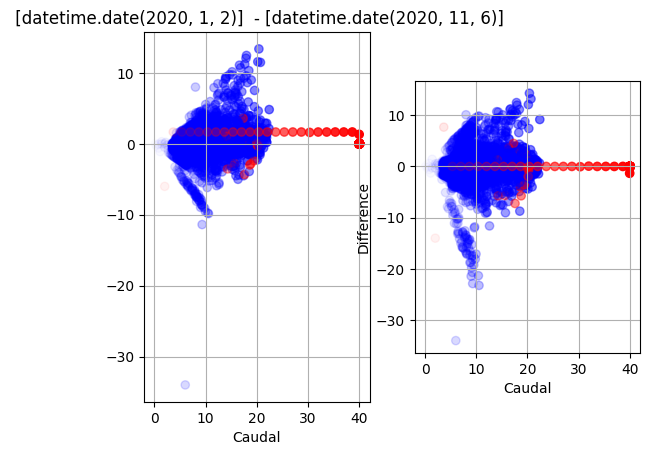

min_value 2.09


C:\Users\Francisco\AppData\Local\Temp\ipykernel_2168\1984558882.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:


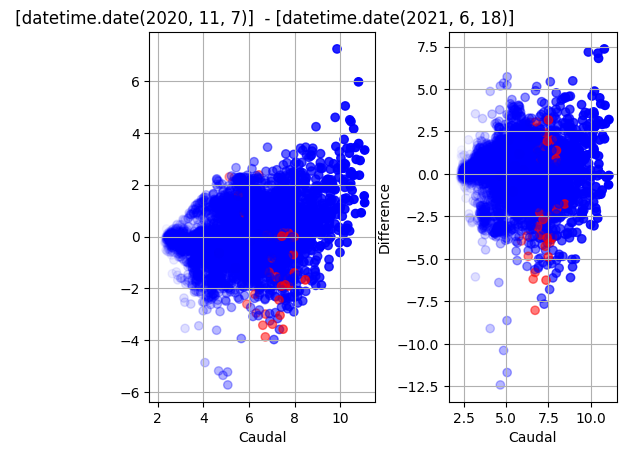

min_value -20.0


C:\Users\Francisco\AppData\Local\Temp\ipykernel_2168\1984558882.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:


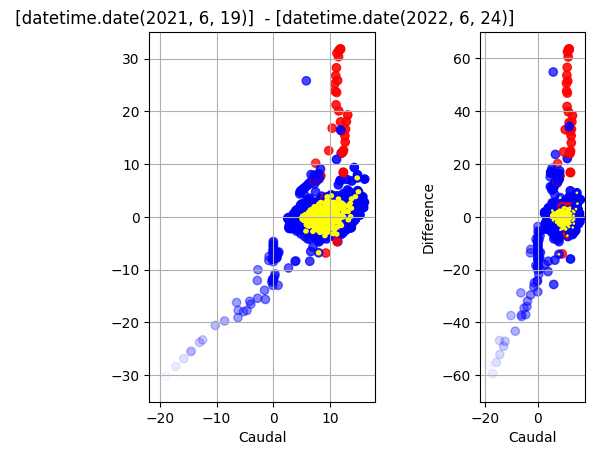

min_value -8.33


C:\Users\Francisco\AppData\Local\Temp\ipykernel_2168\1984558882.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:


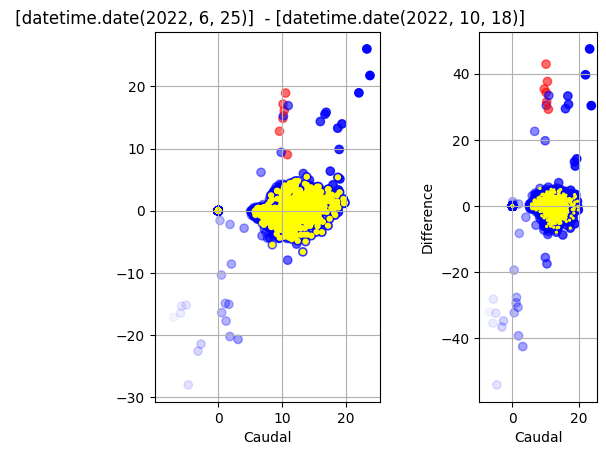

In [3]:
def scatterDataLists(data):
    for index, df in enumerate(data):
        colors = ['red' if df['zscore'][i] > zscore_limit else 'blue' for i in range(len(df))]
        min_value = df['Caudal'].min()
        print('min_value', min_value)
        max_value = df['Caudal'].max()
        df['Caudal_normalized'] = (df['Caudal'] - min_value) / (max_value - min_value)
        alpha_values = df['Caudal_normalized']

        dateStart = df.head(1).index.date
        dateEnd = df.tail(1).index.date
        title = f' {dateStart}  - {dateEnd}'

        fig, ax = plt.subplots(1, 2)
        # Plot the data in the first subplot
        ax[0].scatter(df['Caudal'], df['diff'], c = colors, alpha=alpha_values)
        ax[0].set_title(title)
        ax[0].set_xlabel('Caudal')
        # Add a grid to the first subplot
        ax[0].grid()


        ax[1].scatter(df['Caudal'], df['diff2'], c = colors,  alpha=alpha_values)

        ax[1].set_xlabel('Caudal')
        ax[1].set_ylabel('Difference')
        ax[1].set_aspect('equal')
        ax[1].grid()
        for i, row in df.iterrows():
            if row.name in modified_dates:
                #print(row)
                circ = Circle((row['Caudal'], row['diff']), radius=0.5, facecolor='yellow', alpha=1)
                ax[0].add_patch(circ)

                circ2 = Circle((row['Caudal'], row['diff2']), radius=0.5, facecolor='yellow', alpha=1)
                ax[1].add_patch(circ2)
                ax[1].set_aspect('equal')
        
        plt.show() 
    
scatterDataLists(dataSetList)

8.310495947488585 4.397862066978303
4.2465753424653647e-05 1.6589271612718193


C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5.665103813293127 1.7134557947525733
0.0003863550697323772 1.0167163886524224
7.36098356438335 2.3312458442004704
0.0004030754892823823 2.382231054396417
7.296656175059952 5.455854962174379
-0.005708633093525167 2.290218439574484


C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

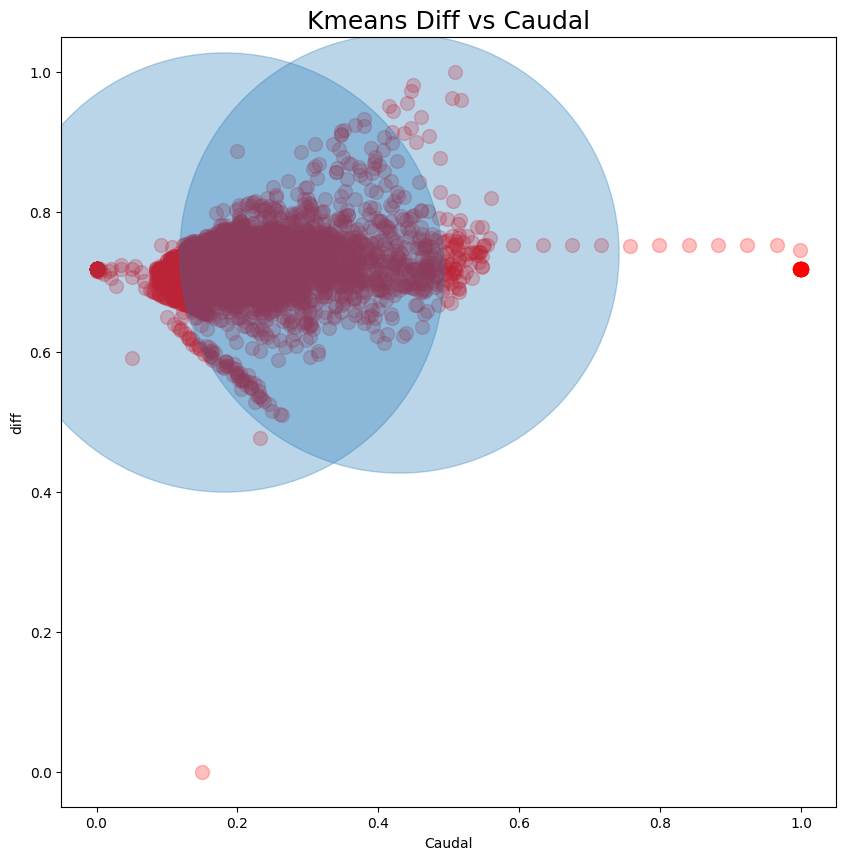

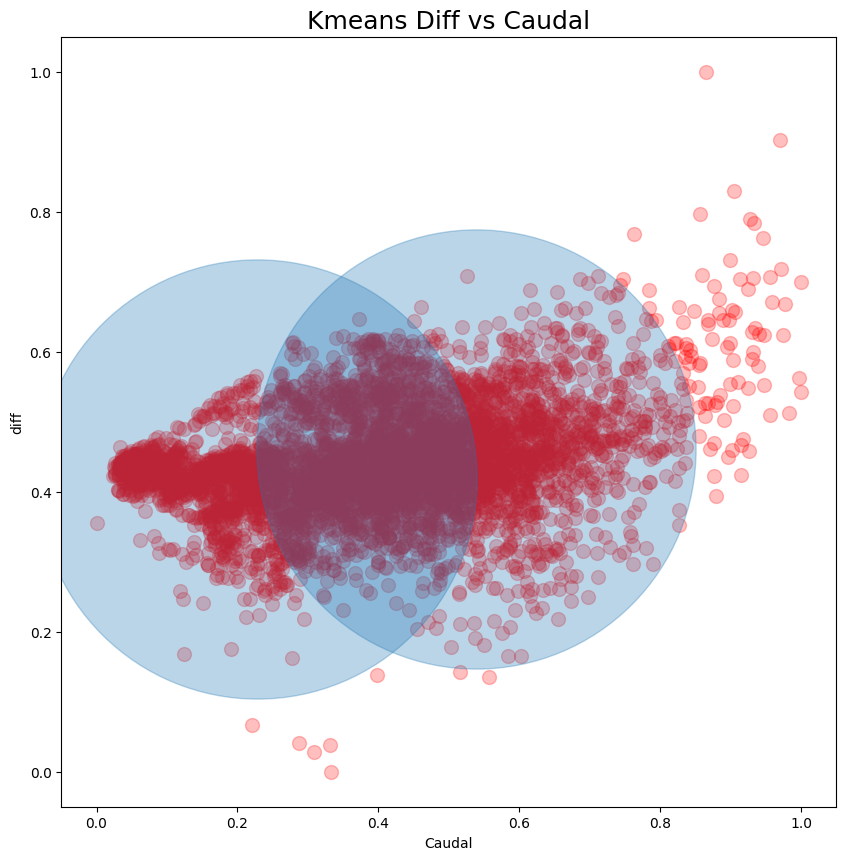

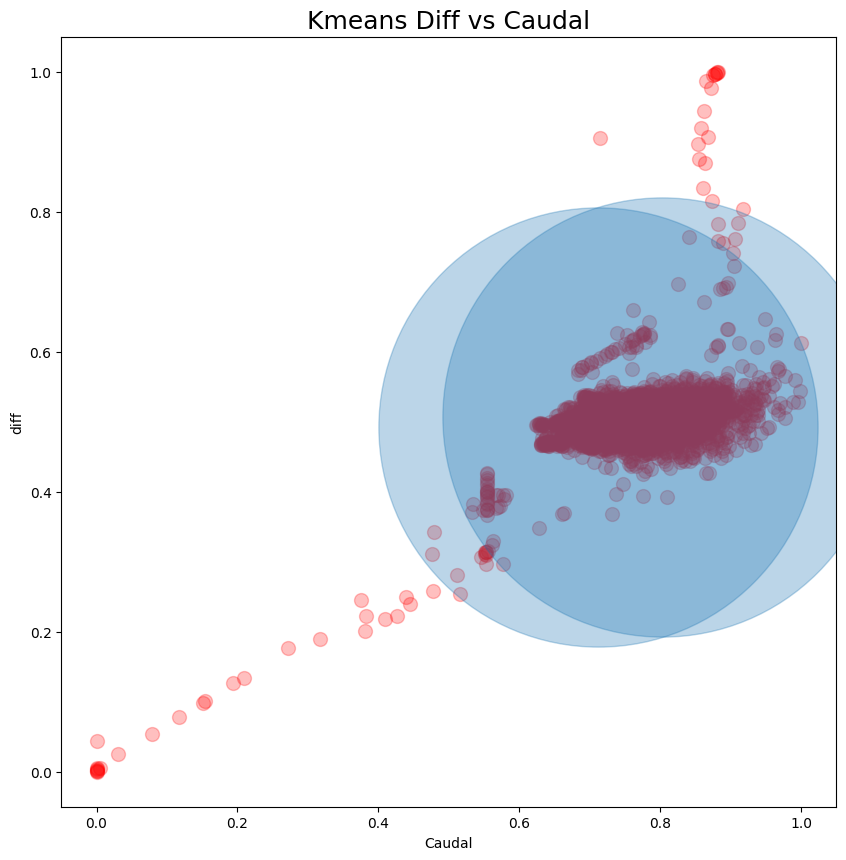

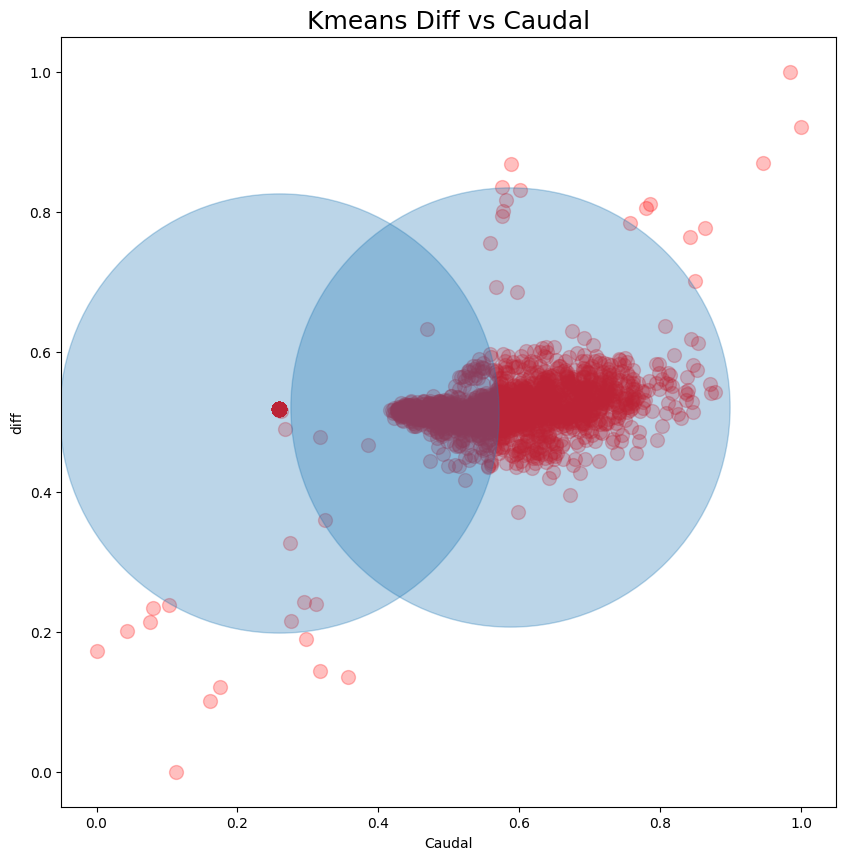

In [3]:
def scatterKmeans(df):
    # set the x and y variables
    col_x = 'Caudal'
    col_y = 'diff'

    x_mean = df[col_x].mean()
    x_stdev = df[col_x].std()

    y_mean = df[col_y].mean()
    y_stdev = df[col_y].std()

    print(x_mean, x_stdev)
    print(y_mean, y_stdev)

    # calculate the normalised values on x and y
    x_min = min(df[col_x])
    x_max = max(df[col_x])

    norm_x = ((df[col_x] - x_min)/(x_max - x_min))
    df['norm_x'] = norm_x

    y_min = min(df[col_y])
    y_max = max(df[col_y])

    norm_y = ((df[col_y] - y_min)/(y_max - y_min))
    df['norm_y'] = norm_y
    
    x_y = np.column_stack((df['norm_x'], df['norm_y']))
    km_res = KMeans(n_clusters=2).fit(x_y)
    clusters = km_res.cluster_centers_
    clusters

    figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')

    plt.xlabel(col_x)
    plt.ylabel(col_y)

    plt.scatter(df.norm_x, df.norm_y, alpha = 0.25, s = 100, color='red')
    plt.title("Kmeans Diff vs Caudal", fontsize=18)
    plt.scatter(clusters[:,0], clusters[:,1], s = 100000, alpha=0.30)
    


for index, df in enumerate(dataSetList):
    scatterKmeans(df)



In [7]:
def setSupervisedLearning(caudal):
    copyCaudal = caudal.copy()
    copyCaudal = copyCaudal.drop(columns=['mean12', 'Caudal', 'Caudal_normalized','timediff'])
    #copyCaudal = copyCaudal.drop(columns=['mean12', 'Caudal', 'Caudal_normalized', 'norm_x', 'norm_y','timediff'])
    
    #copyCaudal['Y'] = [2 if caudal <= 0 else 1 if row in modified_dates else 0 for caudal, row in zip(copyCaudal['prev_1'], copyCaudal.index.date)]
    #copyCaudal['Y'] = [2 if caudal <= 0 else 0 for caudal in copyCaudal['prev_1']]
    copyCaudal['Y'] = [1 if row in modified_dates else 0 for row in copyCaudal.index.date]
    
    #print(copyCaudal.loc[copyCaudal['Y'] == 1].count())
    #cau = cau.loc[cau.index < '2022-6-09']
    copyCaudal.dropna(inplace=True)
    return copyCaudal


supervisedList = []
for index, df in enumerate(dataSetList):
    supervisedList.append(setSupervisedLearning(df))

In [8]:
supervisedList[3]

,zscore,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,diff,diff2,Y
Tempo,,,,,,,,,,,,,,,,
2022-06-25 20:37:09,1.419780,15.87,15.46,13.73,13.99,13.37,13.88,13.72,14.00,14.83,13.70,13.34,13.19,-0.60,-1.01,1
2022-06-25 21:37:09,1.444990,15.27,15.87,15.46,13.73,13.99,13.37,13.88,13.72,14.00,14.83,13.70,13.34,0.14,0.74,1
2022-06-25 22:37:09,1.183880,15.41,15.27,15.87,15.46,13.73,13.99,13.37,13.88,13.72,14.00,14.83,13.70,-1.45,-1.59,1
2022-06-25 23:37:09,0.841736,13.96,15.41,15.27,15.87,15.46,13.73,13.99,13.37,13.88,13.72,14.00,14.83,-1.90,-0.45,1
2022-06-26 00:37:00,0.780510,12.06,13.96,15.41,15.27,15.87,15.46,13.73,13.99,13.37,13.88,13.72,14.00,-0.34,1.56,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-18 19:37:59,-1.329979,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
2022-10-18 20:37:57,-1.329979,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
2022-10-18 21:37:57,-1.329979,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [10]:
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import confusion_matrix,recall_score, precision_score, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [17]:
def getMetrics(Y_test, prediction_test):
     
    # metrics
    print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))
    print("recall_score = ", metrics.recall_score(Y_test, prediction_test))
    print("precision_score = ", metrics.precision_score(Y_test, prediction_test))
    print("f1_score = ", metrics.f1_score(Y_test, prediction_test))
    
    # Calculate the TPR and FPR at different classification thresholds
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, prediction_test)
    # Calculate the AUC
    auc = metrics.auc(fpr, tpr)

    print("TPR:", tpr)
    print("FPR:", fpr)
    print("AUC:", auc)

In [12]:
def train(caudal):
    data = caudal.copy()
    Y = data['Y']
    Y = Y.astype('int')
    X = data.drop(labels=['Y'], axis=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=30)
    model = RandomForestClassifier(n_estimators= 1000, random_state=30, n_jobs=-1)
    model.fit(X_train, Y_train)
    
    feature_list = list(X.columns)
    feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
    print(feature_imp)
    return model

bestModel = train(supervisedList[3])
#bestModel = train(allData)


zscore     0.086633
prev_12    0.074771
prev_2     0.074170
prev_1     0.073940
prev_7     0.072485
prev_6     0.071395
prev_3     0.069625
prev_4     0.065663
prev_5     0.065445
prev_11    0.064467
prev_10    0.064094
prev_8     0.063091
prev_9     0.060700
diff2      0.047254
diff       0.046267
dtype: float64


In [16]:

def predict(data, model):
    caudal = data.copy()
    Y = caudal['Y']
    Y = Y.astype('int')
    X = caudal.drop(labels=['Y'], axis=1)
    prediction_test = model.predict(X)
    #conf_matrix = confusion_matrix(Y, prediction_test)
    # Use matplotlib to create a heatmap of the confusion matrix
    #plt.imshow(conf_matrix, cmap='binary')
    #plt.colorbar()
    
    print(getMetrics(Y, prediction_test))
    return prediction_test

#  todo fazer medias dos ultimos n dias em cada row 

In [19]:
allData = pd.concat(supervisedList)

allData['Y_pred'] = predict(allData, bestModel)
#for index, df in enumerate(supervisedList):
#    supervisedList[index]['Y_pred'] = predict(supervisedList[index], bestModel)

#print(allData[allData['Y_pred'] == 2])

Accuracy =  0.9253650396328744
recall_score =  0.4809934110491637
precision_score =  0.5536756126021003
f1_score =  0.5147816653105505
TPR: [0.         0.48099341 1.        ]
FPR: [0.         0.03477747 1.        ]
AUC: 0.7231079706971054
None


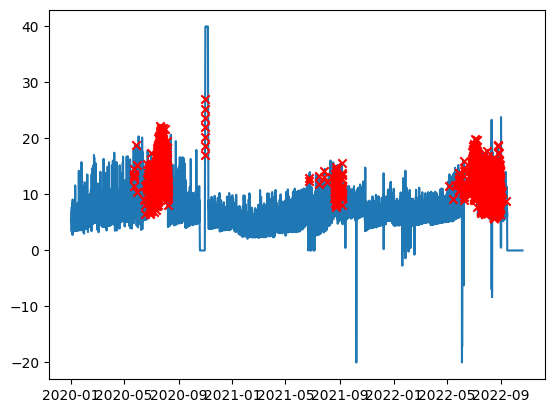

In [20]:

def plotPredict(df):
    plt.plot(df.index, df['prev_1'])
    mask = df['Y_pred'] == 1
    mask2 = df['Y_pred'] == 2
    
    x = df[mask].index
    y = df[mask]['prev_1']
    x1 = df[mask2].index
    y1 = df[mask2]['prev_1']
    plt.scatter(x, y, c='r', marker='x', zorder=2)
    plt.scatter(x1, y1, c='yellow', marker='x', zorder=2)
    
    
plotPredict(allData)

# Iterate over the list of data frames and the subplots
#for df, ax in zip(supervisedList, axs.flatten()):
    # Plot the 'prev_1' column of the data frame on the current subplot
#    plotPredict(df)

# Show the plot






#supervisedList[0]['Y_pred']